# Programming Assignment 3c: Text classification (Part 3)

- Irene Cánovas Vidal
- Alejandra Sánchez Torres

## Load required libraries

In [1]:
import re
from string import digits

import altair as alt
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score)
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC

import stanza
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics.pairwise import linear_kernel
from sklearn.pipeline import make_pipeline

nltk.download("punkt")
nltk.download("wordnet")

warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martavalero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/martavalero/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load train and test data

In [2]:
# load and check train data
train_df = pd.read_csv("PA3_train.tsv", names = ["Annotations", "Reviews"], sep = "\t")
train_df.head()

,Annotations,Reviews
0,0/0,Ordered my food the hole meal looked dead. pla...
1,1/1,We stopped her whilst walking in the Haga area...
2,0/0,"Bad experience, On 23/03/19 Myself and my part..."
3,0/0,Extremely underwhelming experience here last n...
4,0/0,Waited 30 minutes to get a table…that was ok. ...


In [3]:
# load and check train data
test_df = pd.read_csv("PA3_test.tsv",names = ["Annotations", "Reviews"], sep = "\t")
test_df.head()

,Annotations,Reviews
0,0,Over all I felt a bit disappointing with above...
1,1,A wonderful experience!
2,1,Always very delicious dishes and attentive ser...
3,1,Amazing as always
4,1,"Amazing food, the aubergine mess and the Tunis..."


In [4]:
train_df.shape[0] + test_df.shape[0]

8769

**Data Cleaning**

***Clean Reviews***

Steps taken for cleaning the reviews:

**1. Import libraries**

- re library for regular expressions
- nltk library to work with language data
- download and import english stopwords

**2. Create review_cleaning function to**

- convert all words to lowercase
- remove all emoticons
- substitute multiple spaces with single space

**3. Create LemmaTokenizer class to**

- lemmatize all words in a review that are longer than 1 character and are not punctuations

We decided not to use stemming as it did not improve the accuracy of the models (when used alone or along with lemmatization).

In [5]:
# function to clean reiews
def review_cleaning(review):
    
    # change to lower case
    review = review.lower()

    # deconcatinate words
    review = re.sub(r"n\'t", " not", review)
    review = re.sub(r"\'re", " are", review)
    review = re.sub(r"\'s", " is", review)
    review = re.sub(r"\'d", " would", review)
    review = re.sub(r"\'ll", " will", review)
    review = re.sub(r"\'ve", " have", review)
    review = re.sub(r"\'m", " am", review)

    # remove all emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U000024C2-\U0001F251"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags = re.UNICODE
      )
    review = emoji_pattern.sub(r"", review)

    # substitute multiple spaces with single space
    review =  re.sub(r"\s+", " ", review, flags = re.I)

    # remove punctuations, URLs, and @:
    review = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", review)

    # remove digits
    review = review.translate(str.maketrans("", "", digits))

    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(t) for t in word_tokenize(review) if len(t) > 1]
    review = ' '.join(review)

    return review

In [6]:
# get cleaned reviews for train data
train_df["Reviews_Cleaned"] = train_df["Reviews"].apply(lambda x: review_cleaning(x))
train_df

,Annotations,Reviews,Reviews_Cleaned
0,0/0,Ordered my food the hole meal looked dead. pla...,ordered my food the hole meal looked dead plai...
1,1/1,We stopped her whilst walking in the Haga area...,we stopped her whilst walking in the haga area...
2,0/0,"Bad experience, On 23/03/19 Myself and my part...",bad experience on myself and my partner arrive...
3,0/0,Extremely underwhelming experience here last n...,extremely underwhelming experience here last n...
4,0/0,Waited 30 minutes to get a table…that was ok. ...,waited minute to get table that wa ok sat at t...
...,...,...,...
7013,0/0,"Bad service, stay away",bad service stay away
7014,0/0,"Old school, but not always in a good way. Lots...",old school but not always in good way lot of f...
7015,1/1,Top 5 allergen free restaurant and the food is...,top allergen free restaurant and the food is g...
7016,-1/0,"The ambiance is ok, the service is slightly sl...",the ambiance is ok the service is slightly slo...


In [7]:
# get cleaned reviews for test data
test_df["Reviews_Cleaned"] = test_df["Reviews"].apply(lambda x: review_cleaning(x))

# Clean Annotations

In [8]:
# check unique annotation combinations
train_df["Annotations"].unique()

array(['0/0', '1/1', '1/0', '-1/0', '-1/1', '0/1', '2/1', '2/0', '1/',
       '9/1'], dtype=object)

In [9]:
train_df["Annotations"].value_counts().to_dict()

{'1/1': 3496,
 '0/0': 3126,
 '1/0': 148,
 '0/1': 117,
 '-1/0': 97,
 '-1/1': 28,
 '2/1': 2,
 '2/0': 2,
 '1/': 1,
 '9/1': 1}

In [10]:
test_df["Annotations"].value_counts().to_dict()

{1: 886, 0: 865}

The annotations that have "2/1", "2/0", "1/" and "9/1" are unclear thus we remove them.

In [11]:
# function to remove rows with certain values
def filter_rows_by_values(df, col: str, values):
    return df[~df[col].isin(values)]

In [12]:
# remove the unclear annotations
train_df_clean = filter_rows_by_values(train_df, "Annotations", ["2/1", "2/0", "1/","9/1"])

In [13]:
# function to split annotations
def split_annotations(s):
  s = s.split("/")
  s1 = int(s[0])
  s2 = int(s[1])
  return pd.Series([s1, s2])

In [14]:
# split annotations
train_df_clean[["Annotator2", "Annotator1"]] = train_df_clean["Annotations"].apply(lambda x: split_annotations(x))
train_df_clean.head()

,Annotations,Reviews,Reviews_Cleaned,Annotator2,Annotator1
0,0/0,Ordered my food the hole meal looked dead. pla...,ordered my food the hole meal looked dead plai...,0,0
1,1/1,We stopped her whilst walking in the Haga area...,we stopped her whilst walking in the haga area...,1,1
2,0/0,"Bad experience, On 23/03/19 Myself and my part...",bad experience on myself and my partner arrive...,0,0
3,0/0,Extremely underwhelming experience here last n...,extremely underwhelming experience here last n...,0,0
4,0/0,Waited 30 minutes to get a table…that was ok. ...,waited minute to get table that wa ok sat at t...,0,0


In [15]:
# convert annotations 1 and 2 to list
annotator1 = train_df_clean["Annotator1"].tolist()
annotator2 = train_df_clean["Annotator2"].tolist()

# calculate cohen kappa score
cohen_kappa_score(annotator1, annotator2)

0.8904734252430904

## Dealing with unlear annotations

We will now seperate all unclear annotations i.e. -1 and then perform a sentiment analysis using stanza to re-annotate the reviews. We then cross checked the results with the second annotator.

In [16]:
# # convert annotations from integer to string
# train_df_clean[["Annotator1","Annotator2"]] = train_df_clean[["Annotator1","Annotator2"]].astype(str)
# train_df_clean

In [17]:
# seperate all -1 annotations
train_df_unclear = train_df_clean.loc[train_df_clean["Annotator1"].isin([-1]) | train_df_clean["Annotator2"].isin([-1])]
# train_df_unclear = train_df_clean.loc[train_df_clean["Annotations"].isin(["1/0", "-1/0", "-1/1", "0/1"])]

In [18]:
# remove all uncertainties from train_df_clean and disagreements
train_df_clean = filter_rows_by_values(train_df_clean, "Annotations", ["1/0", "-1/0", "-1/1", "0/1"])
# train_df_clean = filter_rows_by_values(train_df_clean, "An

In [19]:
# reset index of dataframe
train_df_clean.reset_index(drop = True, inplace = True)

In [20]:
# set annotator 2 as final annotation
train_df_clean["Final_Annotation"] = train_df_clean["Annotator1"]
train_df_clean

,Annotations,Reviews,Reviews_Cleaned,Annotator2,Annotator1,Final_Annotation
0,0/0,Ordered my food the hole meal looked dead. pla...,ordered my food the hole meal looked dead plai...,0,0,0
1,1/1,We stopped her whilst walking in the Haga area...,we stopped her whilst walking in the haga area...,1,1,1
2,0/0,"Bad experience, On 23/03/19 Myself and my part...",bad experience on myself and my partner arrive...,0,0,0
3,0/0,Extremely underwhelming experience here last n...,extremely underwhelming experience here last n...,0,0,0
4,0/0,Waited 30 minutes to get a table…that was ok. ...,waited minute to get table that wa ok sat at t...,0,0,0
...,...,...,...,...,...,...
6617,1/1,"We recently dined at Ma Cuisine, and enjoyed e...",we recently dined at ma cuisine and enjoyed ev...,1,1,1
6618,0/0,"Bad service, stay away",bad service stay away,0,0,0
6619,0/0,"Old school, but not always in a good way. Lots...",old school but not always in good way lot of f...,0,0,0
6620,1/1,Top 5 allergen free restaurant and the food is...,top allergen free restaurant and the food is g...,1,1,1


In [21]:
# download stanza english model
print("Downloading English model...")
stanza.download("en")

2023-04-18 13:29:56 INFO: Downloading default packages for language: en (English) ...
2023-04-18 13:30:00 INFO: File exists: /Users/martavalero/stanza_resources/en/default.zip
2023-04-18 13:30:21 INFO: Finished downloading models and saved to /Users/martavalero/stanza_resources.


In [22]:
# create a stanza pipeline
nlp = stanza.Pipeline(lang = "en", processors = "tokenize, sentiment")

2023-04-18 13:30:21 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-04-18 13:30:22 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2023-04-18 13:30:22 INFO: Using device: cpu
2023-04-18 13:30:22 INFO: Loading: tokenize
2023-04-18 13:30:22 INFO: Loading: sentiment
2023-04-18 13:30:23 INFO: Done loading processors!


In [23]:
# function to perform sentiment analysis
# 0 = negative, 1 = neutral, 2 = positive
def get_sentiment(x):
    doc = nlp(x)
    for sentence in doc.sentences:
        return sentence.sentiment

In [24]:
# get the sentiment scores for the unclear review data
train_df_unclear["sent_score"] = train_df_unclear["Reviews"].apply(lambda x:get_sentiment(x))
train_df_unclear

,Annotations,Reviews,Reviews_Cleaned,Annotator2,Annotator1,sent_score
19,-1/0,"restaurant mon ami en las vegas , un verdadero...",restaurant mon ami en la vega un verdadero eng...,-1,0,2
45,-1/1,Love love love this place .. Its kind of small...,love love love this place it kind of small all...,-1,1,2
95,-1/0,"The satay was ok, it was a little tough and sa...",the satay wa ok it wa little tough and sauce w...,-1,0,0
166,-1/1,I loved the ambience of this place. Food was g...,loved the ambience of this place food wa great...,-1,1,2
191,-1/0,The staff is a kind of rude but the foods and ...,the staff is kind of rude but the food and dri...,-1,0,2
...,...,...,...,...,...,...
6821,-1/1,The reason why Taipan Building is most attract...,the reason why taipan building is most attract...,-1,1,2
6915,-1/1,I had the most delicious fish for lunch. Inclu...,had the most delicious fish for lunch included...,-1,1,2
6921,-1/0,"Graffiato is AWESOME. However, warning for th...",graffiato is awesome however warning for those...,-1,0,1
6994,-1/0,Some times this place is good today it wasn't ...,some time this place is good today it wa not n...,-1,0,2


In [25]:
# remove all review with neutral sentiment i.e. 1
train_df_unclear = filter_rows_by_values(train_df_unclear,"sent_score",[1])


In [26]:
# set all positive sentiment score label from 2 to 1
train_df_unclear["sent_score"] = train_df_unclear["sent_score"].apply(lambda x: x if x ==  0 else 1)


In [27]:
# filter all reviews that have same sentiment score as second annotation
train_df_clear = train_df_unclear[train_df_unclear["Annotator1"] ==  train_df_unclear["sent_score"]]


In [28]:
# drop the sent_score column
train_df_clear.drop("sent_score", axis = 1, inplace = True)


In [29]:
# set first annotation as final annotation
train_df_clear["Final_Annotation"] = train_df_clear["Annotator1"]
train_df_clear

,Annotations,Reviews,Reviews_Cleaned,Annotator2,Annotator1,Final_Annotation
45,-1/1,Love love love this place .. Its kind of small...,love love love this place it kind of small all...,-1,1,1
95,-1/0,"The satay was ok, it was a little tough and sa...",the satay wa ok it wa little tough and sauce w...,-1,0,0
166,-1/1,I loved the ambience of this place. Food was g...,loved the ambience of this place food wa great...,-1,1,1
335,-1/0,Sadly this place was a huge disappointment ser...,sadly this place wa huge disappointment servic...,-1,0,0
516,-1/1,This was my only chili crab experience and I s...,this wa my only chili crab experience and sort...,-1,1,1
...,...,...,...,...,...,...
6288,-1/0,Service was pleasant but slow and the two main...,service wa pleasant but slow and the two main ...,-1,0,0
6459,-1/0,We went to the tango show and it was not good ...,we went to the tango show and it wa not good a...,-1,0,0
6821,-1/1,The reason why Taipan Building is most attract...,the reason why taipan building is most attract...,-1,1,1
6915,-1/1,I had the most delicious fish for lunch. Inclu...,had the most delicious fish for lunch included...,-1,1,1


In [30]:
# save the unclear review data with sentiment scores
train_df_clear.to_csv("unsure_reviews_fixed.csv", index = False)


In [31]:
# load the unclear review data with sentiment scores and get a peek
train_df_clear = pd.read_csv("unsure_reviews_fixed.csv")
train_df_clear.head()

,Annotations,Reviews,Reviews_Cleaned,Annotator2,Annotator1,Final_Annotation
0,-1/1,Love love love this place .. Its kind of small...,love love love this place it kind of small all...,-1,1,1
1,-1/0,"The satay was ok, it was a little tough and sa...",the satay wa ok it wa little tough and sauce w...,-1,0,0
2,-1/1,I loved the ambience of this place. Food was g...,loved the ambience of this place food wa great...,-1,1,1
3,-1/0,Sadly this place was a huge disappointment ser...,sadly this place wa huge disappointment servic...,-1,0,0
4,-1/1,This was my only chili crab experience and I s...,this wa my only chili crab experience and sort...,-1,1,1


In [32]:
#train_df_annot = pd.read_csv("PA3_train_annot.tsv", names = ["Annotations", "Reviews", "Final_Annotation"], sep = "\t")
#train_df_annot

In [33]:
# get cleaned reviews for self annotated train data
#train_df_annot["Reviews_Cleaned"] = train_df_annot["Reviews"].apply(lambda x: review_cleaning(x))
#train_df_annot

In [34]:
# merge both clean and now clear reviews and get a peek
train_df_final = pd.concat([train_df_clean[["Final_Annotation", "Reviews", "Reviews_Cleaned"]], 
                            train_df_clear[["Final_Annotation", "Reviews", "Reviews_Cleaned"]]])
                            #train_df_annot[["Final_Annotation", "Reviews", "Reviews_Cleaned"]]])
train_df_final.head()

,Final_Annotation,Reviews,Reviews_Cleaned
0,0,Ordered my food the hole meal looked dead. pla...,ordered my food the hole meal looked dead plai...
1,1,We stopped her whilst walking in the Haga area...,we stopped her whilst walking in the haga area...
2,0,"Bad experience, On 23/03/19 Myself and my part...",bad experience on myself and my partner arrive...
3,0,Extremely underwhelming experience here last n...,extremely underwhelming experience here last n...
4,0,Waited 30 minutes to get a table…that was ok. ...,waited minute to get table that wa ok sat at t...


In [65]:
train_df_final.shape

(6685, 3)

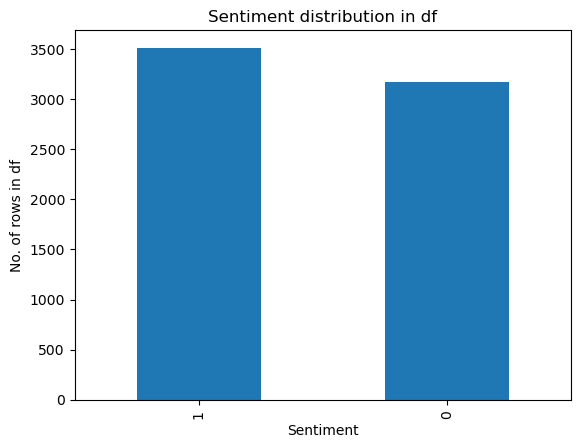

In [35]:
# check the distribution of positive vs negative reviews
plt.figure()
pd.value_counts(train_df_final["Final_Annotation"]).plot.bar(title = "Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

# Text Classification

In [36]:
# set X_train, Y_train, X_test and Y_test
X_train = train_df_final["Reviews_Cleaned"]
Y_train = train_df_final["Final_Annotation"]
X_test = test_df["Reviews_Cleaned"]
Y_test = test_df["Annotations"]

In [37]:
X_train.shape

(6685,)

In [38]:
Y_train.shape

(6685,)

## TF-IDF Visualisation

In [39]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_vector = tfidf_vectorizer.fit_transform(X_train)

tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df.loc["00_Document Frequency"] = (tfidf_df > 0).sum()

tfidf_df = tfidf_df.drop("00_Document Frequency", errors="ignore")

tfidf_stacked_df = tfidf_df.stack().reset_index()

tfidf_stacked_df = tfidf_stacked_df.rename(columns={0:"tfidf", "level_0": "review","level_1": "term", "level_2": "term"})

top_tfidf = tfidf_stacked_df.sort_values(by = ["review", "tfidf"], ascending = [True, False]).groupby(["review"]).head(5)

top_tfidf = top_tfidf.tail(100)

top_tfidf

,review,term,tfidf
66705121,6665,comment,0.303113
66706413,6665,except,0.293541
66712492,6665,tripadvisor,0.287128
66711402,6665,smile,0.281518
66710364,6665,rather,0.258361
...,...,...,...
66901520,6684,slightly,0.424071
66893489,6684,above,0.393854
66893757,6684,ambiance,0.336656
66901528,6684,slow,0.304470


In [40]:
tfidf_df_few =  tfidf_df[['aback', 'abandoned', 'abdul', 'abe', 'abhimanyu', 'ability']]
tfidf_df_few

,aback,abandoned,abdul,abe,abhimanyu,ability
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
6680,0.0,0.0,0.0,0.0,0.0,0.0
6681,0.0,0.0,0.0,0.0,0.0,0.0
6682,0.0,0.0,0.0,0.0,0.0,0.0
6683,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
tfidf_df_few.drop_duplicates(subset = ['aback', 'abandoned', 'abdul', 'abe', 'abhimanyu', 'ability'],
                     keep = "first", inplace = True)
tfidf_df_few

,aback,abandoned,abdul,abe,abhimanyu,ability
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1017,0.050263,0.000000,0.000000,0.000000,0.000000,0.000000
1349,0.000000,0.000000,0.000000,0.000000,0.000000,0.136767
1509,0.000000,0.000000,0.397519,0.000000,0.000000,0.000000
1565,0.000000,0.000000,0.391244,0.000000,0.000000,0.000000
3214,0.000000,0.325172,0.000000,0.000000,0.000000,0.000000
3390,0.000000,0.000000,0.000000,0.000000,0.000000,0.183184
4563,0.000000,0.000000,0.459195,0.000000,0.000000,0.000000
4712,0.093010,0.000000,0.000000,0.000000,0.000000,0.000000
6067,0.000000,0.000000,0.000000,0.000000,0.305113,0.000000


In [42]:
print(tfidf_df_few.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &     aback &  abandoned &     abdul &       abe &  abhimanyu &   ability \\
\midrule
0    &  0.000000 &   0.000000 &  0.000000 &  0.000000 &   0.000000 &  0.000000 \\
1017 &  0.050263 &   0.000000 &  0.000000 &  0.000000 &   0.000000 &  0.000000 \\
1349 &  0.000000 &   0.000000 &  0.000000 &  0.000000 &   0.000000 &  0.136767 \\
1509 &  0.000000 &   0.000000 &  0.397519 &  0.000000 &   0.000000 &  0.000000 \\
1565 &  0.000000 &   0.000000 &  0.391244 &  0.000000 &   0.000000 &  0.000000 \\
3214 &  0.000000 &   0.325172 &  0.000000 &  0.000000 &   0.000000 &  0.000000 \\
3390 &  0.000000 &   0.000000 &  0.000000 &  0.000000 &   0.000000 &  0.183184 \\
4563 &  0.000000 &   0.000000 &  0.459195 &  0.000000 &   0.000000 &  0.000000 \\
4712 &  0.093010 &   0.000000 &  0.000000 &  0.000000 &   0.000000 &  0.000000 \\
6067 &  0.000000 &   0.000000 &  0.000000 &  0.000000 &   0.305113 &  0.000000 \\
6458 &  0.000000 &   0.000000 &  0.000000 &  0.134862 &  

In [43]:
alt.data_transformers.disable_max_rows()


# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'review:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["review"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + text).properties(width = 600)

alt.LayerChart(...)

## TF-IDF with Dummy Classifier

In [44]:
# create tf-idf with dummy classifier
pipeline_dclf = make_pipeline(TfidfVectorizer(), DummyClassifier())

# fit the pipeline
pipeline_dclf.fit(X_train, Y_train)

# get the prediction
Y_pred = pipeline_dclf.predict(X_test)

# view the classification report
print(metrics.classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"]))

              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00       865
    Negative       0.51      1.00      0.67       886

    accuracy                           0.51      1751
   macro avg       0.25      0.50      0.34      1751
weighted avg       0.26      0.51      0.34      1751



## TF-IDF with Bernoulli Naive Bayes

In [45]:
# create tf-idf with multinomial naive bayes
pipeline_bnb = make_pipeline(TfidfVectorizer(binary = True), BernoulliNB())

# fit the pipeline
pipeline_bnb.fit(X_train, Y_train)

# get the prediction
Y_pred = pipeline_bnb.predict(X_test)

# view the classification report
print(metrics.classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"]))

              precision    recall  f1-score   support

    Positive       0.92      0.75      0.83       865
    Negative       0.79      0.93      0.86       886

    accuracy                           0.84      1751
   macro avg       0.86      0.84      0.84      1751
weighted avg       0.85      0.84      0.84      1751



## TF-IDF with Multinomial Naive Bayes

In [46]:
# create tf-idf with multinomial naive bayes
pipeline_mnb = make_pipeline(TfidfVectorizer(), MultinomialNB())

# fit the pipeline
pipeline_mnb.fit(X_train, Y_train)

# get the prediction
Y_pred = pipeline_mnb.predict(X_test)

# view the classification report
print(metrics.classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"]))

              precision    recall  f1-score   support

    Positive       0.95      0.95      0.95       865
    Negative       0.95      0.95      0.95       886

    accuracy                           0.95      1751
   macro avg       0.95      0.95      0.95      1751
weighted avg       0.95      0.95      0.95      1751



## TF-IDF with Linear SVC

In [47]:
# create tf-idf with linear svc
pipeline_lsvc = make_pipeline(TfidfVectorizer(), LinearSVC(random_state = 123))

# fit the pipeline
pipeline_lsvc.fit(X_train, Y_train)

# get the prediction
Y_pred = pipeline_lsvc.predict(X_test)

# view the classification report
print(metrics.classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"]))

              precision    recall  f1-score   support

    Positive       0.96      0.97      0.97       865
    Negative       0.97      0.96      0.97       886

    accuracy                           0.97      1751
   macro avg       0.97      0.97      0.97      1751
weighted avg       0.97      0.97      0.97      1751



## Hyperparameter Tuning

In [48]:
# create list of pipelines
pipelines =  [pipeline_bnb, pipeline_mnb, pipeline_lsvc]

# select parameters for each one
param_bnb = {
    "bernoullinb__alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "bernoullinb__fit_prior": [True, False]
}
param_mnb = {
    "multinomialnb__alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "multinomialnb__fit_prior": [True, False]
}
param_lsvc = {
    "linearsvc__C": [1, 10, 100, 1000], 
    "linearsvc__dual": [True, False], 
    "linearsvc__random_state": [123]
}

# create list of params
params_list = [param_bnb, param_mnb, param_lsvc]


In [49]:
# Run gridsearch and use zip to attach each models to their parameters 
best_clf = ""
best_score = -1
best_parameters = {}
for pipe, params in zip(pipelines, params_list): 
    print(f"Testing parameters for {pipe}")
    grid = GridSearchCV(estimator=pipe, param_grid=params, verbose=0, cv=5, n_jobs=-1, scoring="roc_auc").fit(X_train, Y_train)
    if grid.best_score_ > best_score:
        best_clf = grid.best_estimator_
        best_score = grid.best_score_
        best_parameters = grid.best_params_
        best_keys = list(grid.best_estimator_.named_steps.keys())
        if isinstance(grid.best_estimator_.named_steps[best_keys[1]], LinearSVC):
            best_coefs = grid.best_estimator_.named_steps[best_keys[1]].coef_
            best_features = grid.best_estimator_.named_steps[best_keys[0]].get_feature_names_out()
        elif isinstance(grid.best_estimator_.named_steps[best_keys[1]], BernoulliNB):
            best_coefs = grid.best_estimator_.named_steps[best_keys[1]].feature_log_prob_
            best_features = grid.best_estimator_.named_steps[best_keys[0]].get_feature_names_out()
        elif isinstance(grid.best_estimator_.named_steps[best_keys[1]], MultinomialNB):
            best_coefs = grid.best_estimator_.named_steps[best_keys[1]].feature_log_prob_
            best_features = grid.best_estimator_.named_steps[best_keys[0]].get_feature_names_out()
    print("Best parameters set:")
    print(grid.best_estimator_.steps)
    print("\n")
    print(grid.best_score_)
    print("\n")


Testing parameters for Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(binary=True)),
                ('bernoullinb', BernoulliNB())])
Best parameters set:
[('tfidfvectorizer', TfidfVectorizer(binary=True)), ('bernoullinb', BernoulliNB(alpha=0.1))]


0.958837958054217


Testing parameters for Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])
Best parameters set:
[('tfidfvectorizer', TfidfVectorizer()), ('multinomialnb', MultinomialNB(alpha=0.5))]


0.9913131757290566


Testing parameters for Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc', LinearSVC(random_state=123))])
Best parameters set:
[('tfidfvectorizer', TfidfVectorizer()), ('linearsvc', LinearSVC(C=1, dual=False, random_state=123))]


0.9937490380759686




In [50]:
# create tf-idf with multinomial naive bayes
pipeline_bnb_best = make_pipeline(TfidfVectorizer(binary = True), BernoulliNB(alpha = 0.1))

# fit the pipeline
pipeline_bnb_best.fit(X_train, Y_train)

# get the prediction
Y_pred = pipeline_bnb_best.predict(X_test)

# view the classification report
print(metrics.classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"]))

              precision    recall  f1-score   support

    Positive       0.92      0.80      0.85       865
    Negative       0.82      0.93      0.87       886

    accuracy                           0.87      1751
   macro avg       0.87      0.86      0.86      1751
weighted avg       0.87      0.87      0.86      1751



In [51]:
# create tf-idf with multinomial naive bayes
pipeline_mnb_best = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha = 0.5))

# fit the pipeline
pipeline_mnb_best.fit(X_train, Y_train)

# get the prediction
Y_pred = pipeline_mnb_best.predict(X_test)

# view the classification report
print(metrics.classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"]))

              precision    recall  f1-score   support

    Positive       0.94      0.95      0.95       865
    Negative       0.95      0.94      0.95       886

    accuracy                           0.95      1751
   macro avg       0.95      0.95      0.95      1751
weighted avg       0.95      0.95      0.95      1751



In [52]:
# create tf-idf with linear svc
pipeline_lsvc_best = make_pipeline(TfidfVectorizer(), LinearSVC(C = 1, dual = False, random_state = 123))

# fit the pipeline
pipeline_lsvc_best.fit(X_train, Y_train)

# get the prediction
Y_pred = pipeline_lsvc_best.predict(X_test)

# view the classification report
print(metrics.classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"]))

              precision    recall  f1-score   support

    Positive       0.96      0.97      0.97       865
    Negative       0.97      0.96      0.97       886

    accuracy                           0.97      1751
   macro avg       0.97      0.97      0.97      1751
weighted avg       0.97      0.97      0.97      1751



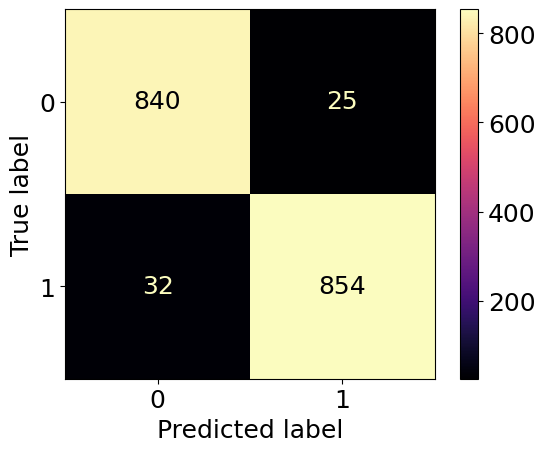

In [84]:
cm = confusion_matrix(Y_test, Y_pred, labels = pipeline_lsvc_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = pipeline_lsvc_best.classes_)
plt.rc('font', size=18)
disp.plot(cmap='magma') # Set the color map for the confusion matrix
plt.show()


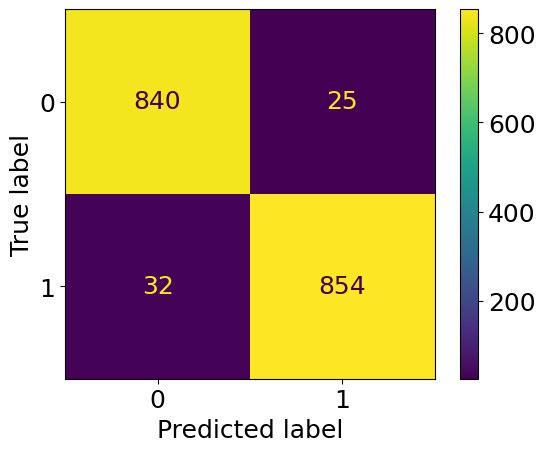

In [53]:
cm = confusion_matrix(Y_test, Y_pred, labels = pipeline_lsvc_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = pipeline_lsvc_best.classes_)
plt.rc('font', size = 18)
disp.plot()
plt.show()

AUC: 0.994


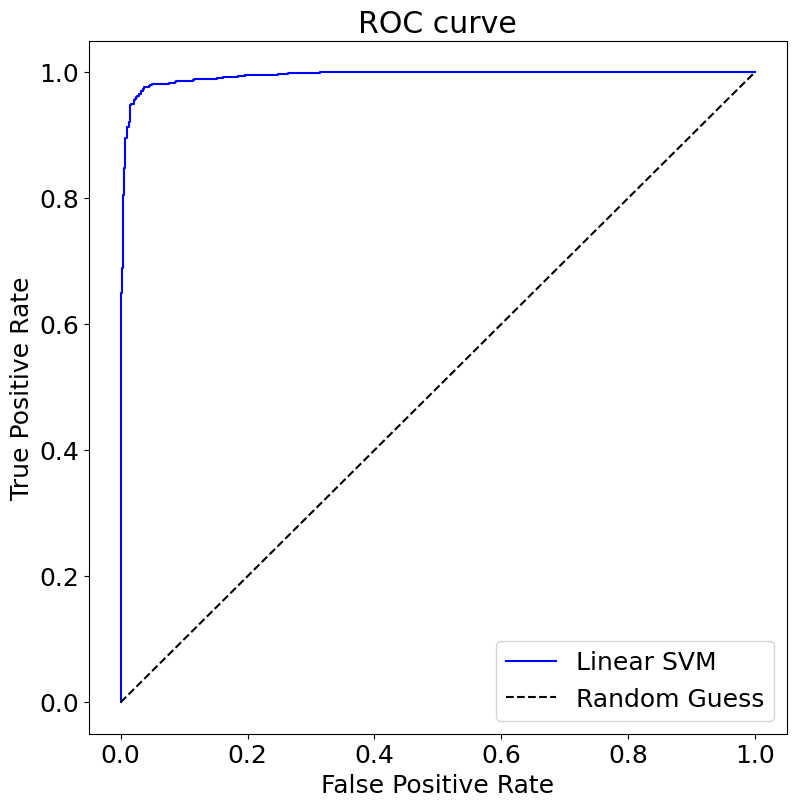

In [54]:
decision_scores = pipeline_lsvc_best.decision_function(X_test)
fpr, tpr, thres = roc_curve(Y_test, decision_scores)
print("AUC: {:.3f}".format(roc_auc_score(Y_test, decision_scores)))

# roc curve
plt.figure(figsize = (9, 9))
plt.plot(fpr, tpr, "b", label = "Linear SVM")
plt.plot([0,1],[0,1], "k--", label = "Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "best")
plt.title("ROC curve")
plt.show()

In [55]:
# get a missclassified review
misclassified = (Y_pred != Y_test)
X_test[misclassified]

43                    no reasonably priced set lunch menu
83      they don have chef and they just warm the food...
174     visited monsoon on friday th november with fri...
196     while visiting london and staying in brick lan...
205     if you have vegan in your group would recommen...
258     my favourite place in hong kong for peking duc...
281          nicest chinese restaurant have been in while
287     vinegarry wine bored looking staff and all the...
300     atmosphere is good however the food wa not ver...
325     this wa my first time and ca not wait until th...
337     this is small ramen restaurant waited so long ...
386     could not recommend this restaurant highly enough
468     nice sushi place just bit of the main walking ...
483     the staff is bit untrained and difficult to ge...
525     am very picky eater who dislike pork however s...
532     certainly not for asian food gourmet tasteless...
536     one nice thing wa that they added gratuity on ...
545     travel

In [56]:
test_df.iloc[83]

Annotations                                                        0
Reviews            They don‚Äôt have a chef and they just warm th...
Reviews_Cleaned    they don have chef and they just warm the food...
Name: 83, dtype: object

In [57]:
print(test_df["Reviews"][83])

They don‚Äôt have a chef and they just warm the foods because they‚Äôre already cooked it and it comes in packaged when you order they just warm the food and topped with oil to look nice


In [58]:
Y_pred[83]

1

In [59]:
decision_scores = pipeline_dclf.predict_proba(X_test)[:, 1]
# fpr, tpr, thres = roc_curve(Y_test, decision_scores)
print("AUC: {:.2f}".format(roc_auc_score(Y_test, decision_scores)))

AUC: 0.50


In [60]:
decision_scores = pipeline_bnb_best.predict_proba(X_test)[:, 1]
fpr, tpr, thres = roc_curve(Y_test, decision_scores)
print("AUC: {:.2f}".format(roc_auc_score(Y_test, decision_scores)))

AUC: 0.96


In [61]:
decision_scores = pipeline_mnb_best.predict_proba(X_test)[:, 1]
# fpr, tpr, thres = roc_curve(Y_test, decision_scores)
print("AUC: {:.2f}".format(roc_auc_score(Y_test, decision_scores)))

AUC: 0.99


## Feature Importance

In [76]:
# create tf-idf with linear svc
pipeline_lsvc = make_pipeline(TfidfVectorizer(), LinearSVC(random_state = 123))

# fit the pipeline
pipeline_lsvc.fit(X_train, Y_train)

# get the prediction
Y_pred = pipeline_lsvc.predict(X_test)

# get the vectorizer and feature names
vectorizer = pipeline_lsvc.named_steps['tfidfvectorizer']
feature_names = vectorizer.get_feature_names_out()

# get the coefficients of the linear SVM model
coef = pipeline_lsvc.named_steps['linearsvc'].coef_[0]

# sort the feature importances in descending order
importances = sorted(zip(coef, feature_names), reverse=True)[:10]

# print the top 10 most important features
print("\nTop 10 most important features:")
for i, (coef, feature) in enumerate(importances):
    print("%d. %s (%f)" % (i + 1, feature, coef))




Top 10 most important features:
1. delicious (3.909487)
2. excellent (3.629570)
3. great (3.289118)
4. amazing (3.027458)
5. best (2.526588)
6. good (2.433084)
7. loved (2.117397)
8. perfect (2.101899)
9. love (2.017767)
10. fantastic (1.953698)


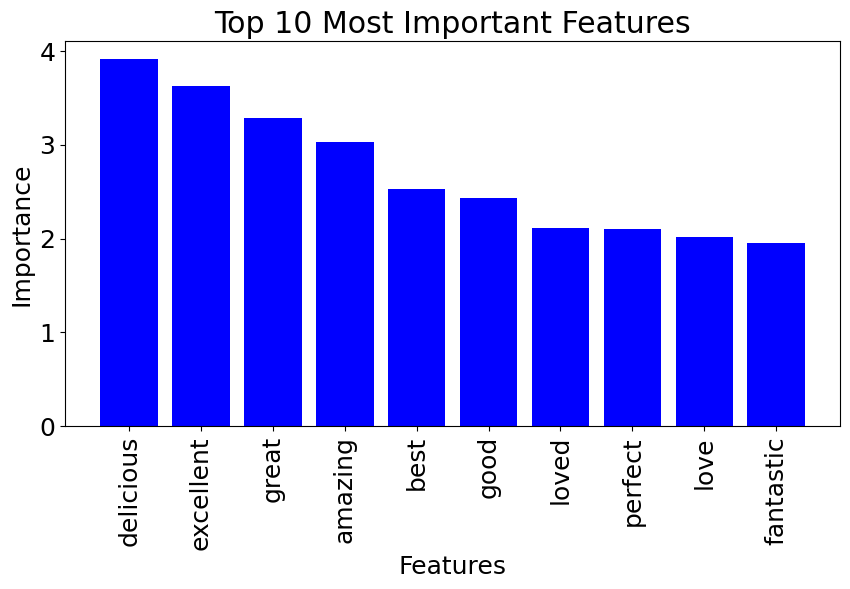

In [78]:
import matplotlib.pyplot as plt

# create tf-idf with linear svc
pipeline_lsvc = make_pipeline(TfidfVectorizer(), LinearSVC(random_state = 123))

# fit the pipeline
pipeline_lsvc.fit(X_train, Y_train)

# get the prediction
Y_pred = pipeline_lsvc.predict(X_test)

# get the vectorizer and feature names
vectorizer = pipeline_lsvc.named_steps['tfidfvectorizer']
feature_names = vectorizer.get_feature_names_out()

# get the coefficients of the linear SVM model
coef = pipeline_lsvc.named_steps['linearsvc'].coef_[0]

# sort the feature importances in descending order
importances = sorted(zip(coef, feature_names), reverse=True)[:10]

# extract the feature names and coefficients
feature_names = [f[1] for f in importances]
coefficients = [f[0] for f in importances]

# create a bar chart of the top features
plt.figure(figsize=(10, 5))
plt.bar(feature_names, coefficients, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Most Important Features')
plt.show()


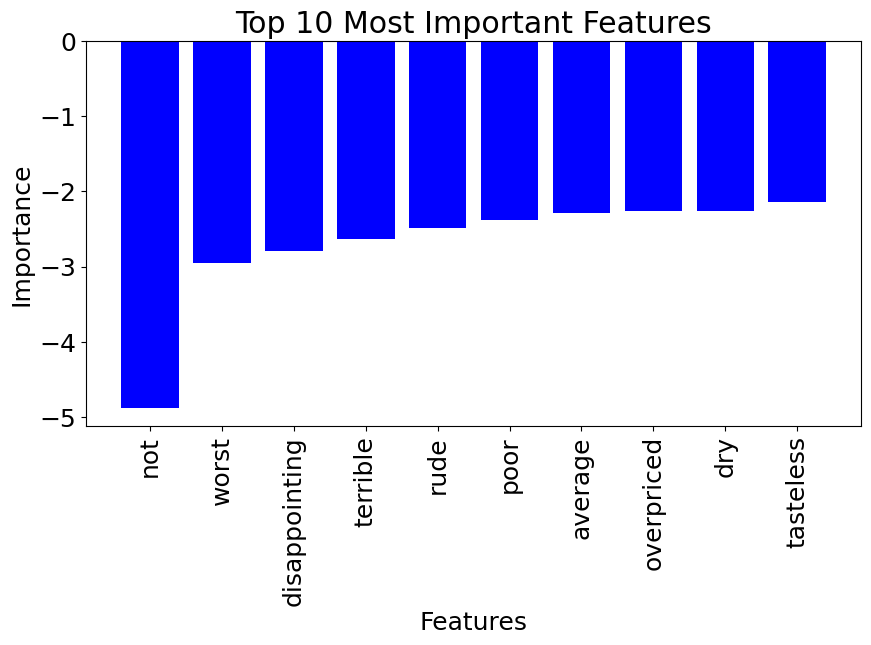

In [85]:
# create tf-idf with linear svc
pipeline_lsvc = make_pipeline(TfidfVectorizer(), LinearSVC(random_state = 123))

# fit the pipeline
pipeline_lsvc.fit(X_train, Y_train)

# get the prediction
Y_pred = pipeline_lsvc.predict(X_test)

# get the vectorizer and feature names
vectorizer = pipeline_lsvc.named_steps['tfidfvectorizer']
feature_names = vectorizer.get_feature_names_out()

# get the coefficients of the linear SVM model
coef = pipeline_lsvc.named_steps['linearsvc'].coef_[0]

# sort the feature importances in ascending order
importances = sorted(zip(coef, feature_names), key=lambda x: x[0])[:10]
# extract the feature names and coefficients
feature_names = [f[1] for f in importances]
coefficients = [f[0] for f in importances]

# create a bar chart of the top features
plt.figure(figsize=(10, 5))
plt.bar(feature_names, coefficients, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Most Important Features')
plt.show()

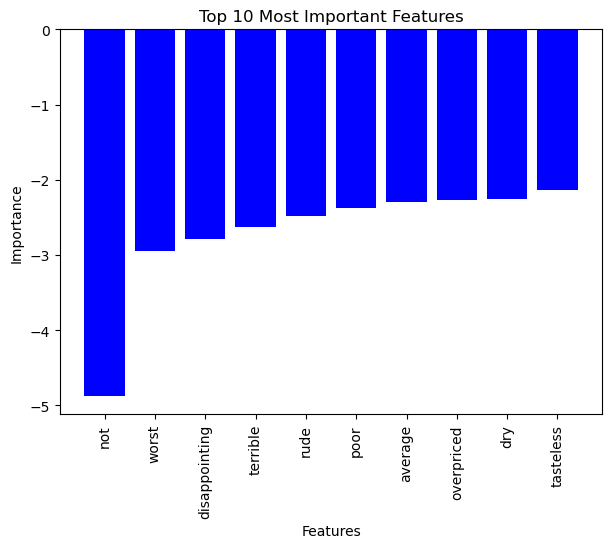

In [121]:
# create tf-idf with linear svc
pipeline_lsvc = make_pipeline(TfidfVectorizer(), LinearSVC(random_state = 123))

# fit the pipeline
pipeline_lsvc.fit(X_train, Y_train)

# get the prediction
Y_pred = pipeline_lsvc.predict(X_test)

# get the vectorizer and feature names
vectorizer = pipeline_lsvc.named_steps['tfidfvectorizer']
feature_names = vectorizer.get_feature_names_out()

# get the coefficients of the linear SVM model
coef = pipeline_lsvc.named_steps['linearsvc'].coef_[0]

# sort the feature importances in ascending order
importances = sorted(zip(coef, feature_names), key=lambda x: x[0])[:10]
# extract the feature names and coefficients
feature_names = [f[1] for f in importances]
coefficients = [f[0] for f in importances]

# create a bar chart of the top features
plt.figure(figsize=(7, 5))
plt.bar(feature_names, coefficients, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Most Important Features')

# increase the size of the figure
fig = plt.gcf()
fig.set_size_inches(7, 5)

# save the figure
plt.savefig('gfg.png', dpi=100)

plt.show()

